In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext timeit

The timeit module is not an IPython extension.


In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [10]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_category)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return np.array(items)

Overwriting load_blockwise.py


In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2430.99 MiB, increment: 2126.19 MiB
CPU times: user 4min 27s, sys: 2.19 s, total: 4min 29s
Wall time: 4min 31s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1772.25 MiB, increment: 473.09 MiB
CPU times: user 1min 3s, sys: 592 ms, total: 1min 4s
Wall time: 1min 4s


In [13]:
train_y = np.vstack([train_y, train_yy]).T
test_y = np.vstack([test_y, test_yy]).T

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [14]:
%%file cnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, InputLayer
from kapre.time_frequency import Melspectrogram, Spectrogram

from keras.wrappers.scikit_learn import KerasClassifier

SR=16000

class CNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=128, validation_split=0.05,
                       a_epochs=50, a_batch_size=128,
                       i_epochs=50, i_batch_size=128,
                       verbose=1):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=SR * 5,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=SR * 5,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=SR * 5,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        for x in X:
            prob = self.clf.predict(x, verbose=0).squeeze()
            if prob == 0:
                pred = self.a_clf.predict(x, verbose=0).squeeze()
            elif prob == 1:
                pred = self.i_clf.predict(x, verbose=0).squeeze()
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()

        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze(),prob[0])

        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze(),prob[1])
        
        probs = [None] * 50
        for counter, j in enumerate(self.a_clf.classes_):
            probs[j] = prob_a[counter]
        for counter, j in enumerate(self.i_clf.classes_):
            probs[j] = prob_i[counter]
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.summary()


        return model

    def deep_net_a(self, feature_count):
        # Create Model
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(18, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Melspectrogram(
            sr=SR,
            n_mels=128,
            power_melgram=1.0,
            input_shape=(1, feature_count),
            trainable_fb=False,
            fmin = 800,
            fmax = 8000
        ))
        model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
        model.add(MaxPooling2D((25, 17)))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting cnnmult.py


In [15]:
from cnnmult import CNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

clf = CNN_Multilayer()

clf.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

Epoch 50/50
1520/1520 [==============================] - 41s 27ms/step - loss: 0.0519 - acc: 0.9816 - val_loss: 1.7303 - val_acc: 0.8000
Train on 547 samples, validate on 29 samples
Epoch 1/50
547/547 [==============================] - 15s 28ms/step - loss: 2.8878 - acc: 0.0457 - val_loss: 2.9034 - val_acc: 0.0000e+00
Epoch 2/50
547/547 [==============================] - 15s 28ms/step - loss: 2.8633 - acc: 0.0786 - val_loss: 2.8989 - val_acc: 0.0345
Epoch 3/50
547/547 [==============================] - 15s 28ms/step - loss: 2.8236 - acc: 0.0804 - val_loss: 2.8928 - val_acc: 0.0000e+00
Epoch 4/50
547/547 [==============================] - 15s 27ms/step - loss: 2.7736 - acc: 0.1024 - val_loss: 2.8660 - val_acc: 0.0000e+00
Epoch 5/50
547/547 [==============================] - 14s 26ms/step - loss: 2.7239 - acc: 0.1042 - val_loss: 2.8155 - val_acc: 0.0000e+00
Epoch 6/50
547/547 [==============================] - 14s 25ms/step - loss: 2.6723 - acc: 0.1243 - val_loss: 2.7357 - val_acc: 0.034

Epoch 10/50
972/972 [==============================] - 26s 26ms/step - loss: 3.0608 - acc: 0.1337 - val_loss: 3.1347 - val_acc: 0.1346
Epoch 11/50
972/972 [==============================] - 26s 27ms/step - loss: 3.0338 - acc: 0.1574 - val_loss: 3.0837 - val_acc: 0.0962
Epoch 12/50
972/972 [==============================] - 27s 27ms/step - loss: 2.9698 - acc: 0.1708 - val_loss: 3.0732 - val_acc: 0.1731
Epoch 13/50
972/972 [==============================] - 26s 26ms/step - loss: 2.9395 - acc: 0.1780 - val_loss: 2.9563 - val_acc: 0.2115
Epoch 14/50
972/972 [==============================] - 27s 28ms/step - loss: 2.9020 - acc: 0.1975 - val_loss: 2.9178 - val_acc: 0.2308
Epoch 15/50
972/972 [==============================] - 26s 26ms/step - loss: 2.8504 - acc: 0.1944 - val_loss: 2.8763 - val_acc: 0.2500
Epoch 16/50
972/972 [==============================] - 25s 26ms/step - loss: 2.8331 - acc: 0.2047 - val_loss: 2.8405 - val_acc: 0.2692
Epoch 17/50
972/972 [==============================] - 

CNN_Multilayer(a_batch_size=128, a_epochs=50, batch_size=128, epochs=50,
        i_batch_size=128, i_epochs=50, validation_split=0.05, verbose=1)

In [16]:
print(test_X[:, np.newaxis, :, :].shape)

(400, 1, 1, 80000)


0.325
Confusion matrix, without normalization
[[1 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


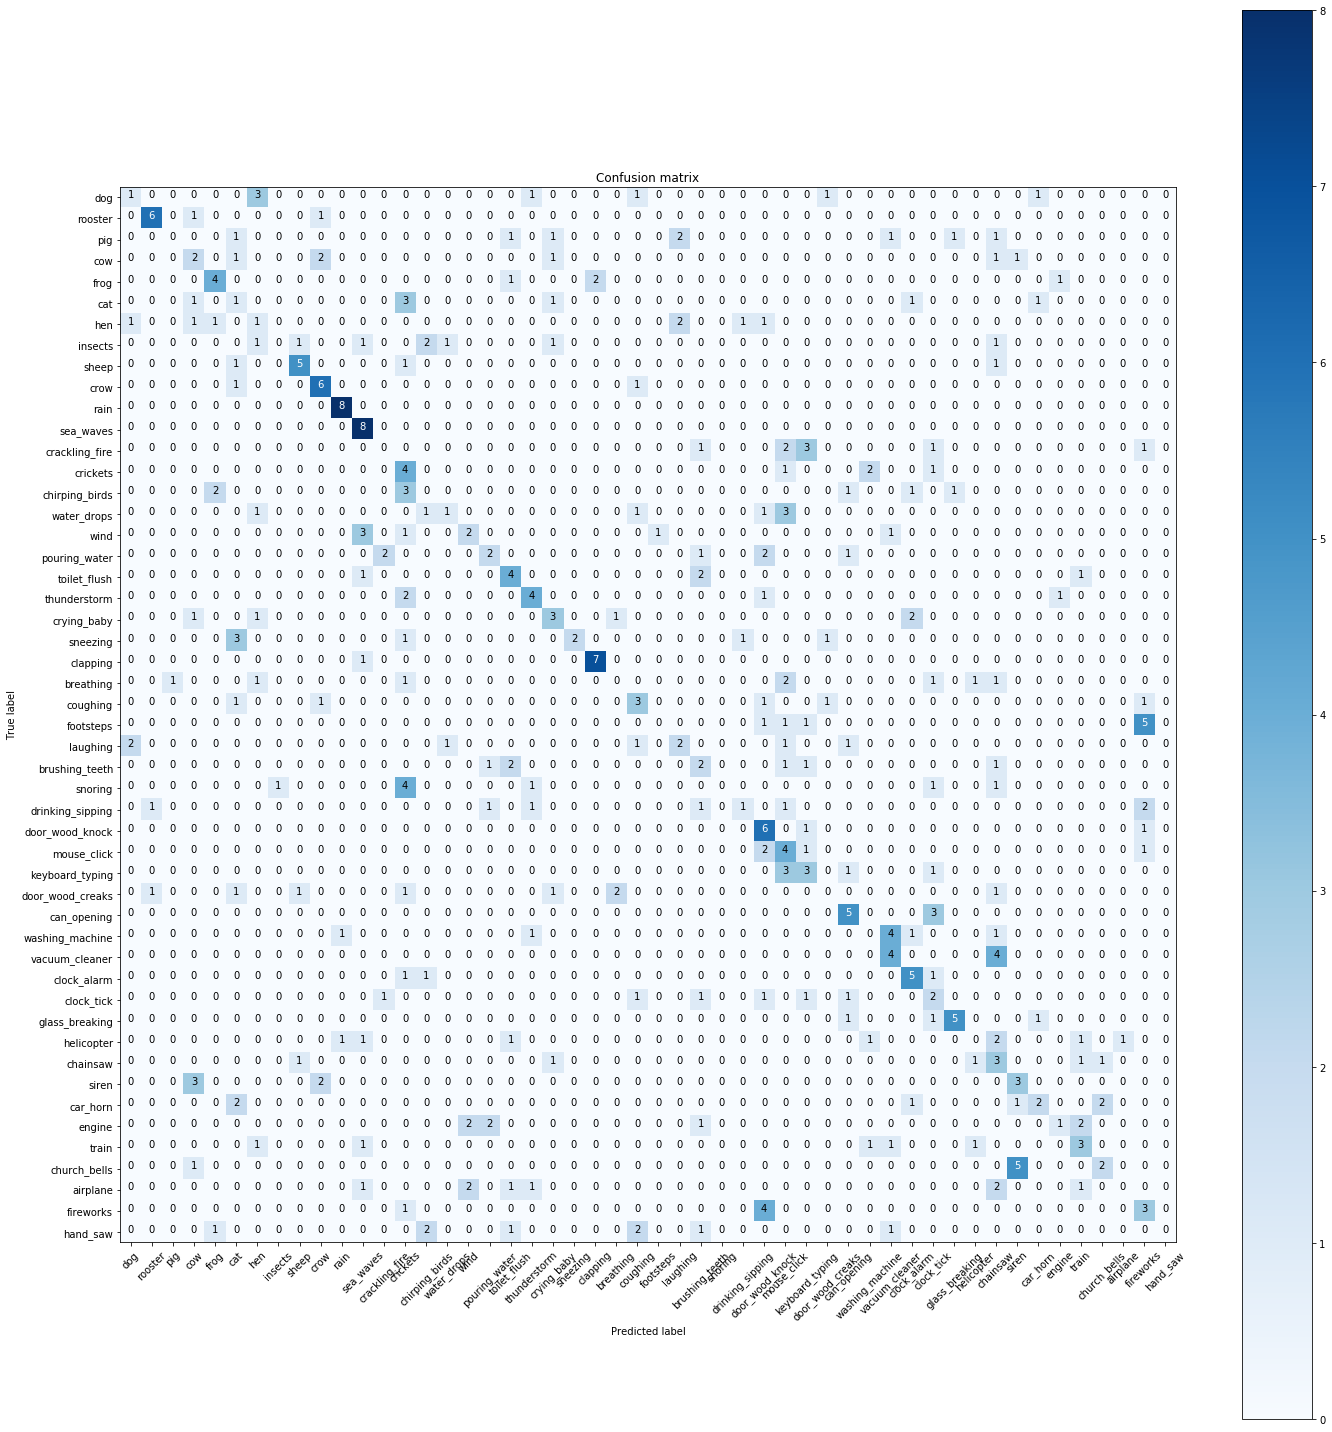

In [17]:
pred = clf.predict(test_X[:, np.newaxis, :, :])
print(metrics.accuracy_score(test_y[:,1], pred))
cm = metrics.confusion_matrix(test_y[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [18]:
%%time
import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

test = dataset[dataset.fold == 1].reset_index()
    
for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



	File Time: 0.21581697463989258
	File Time: 0.21729326248168945
	File Time: 0.2505173683166504
	File Time: 0.23506832122802734
	File Time: 0.2470402717590332
	File Time: 0.2113633155822754
	File Time: 0.25275588035583496
	File Time: 0.2541084289550781
	File Time: 0.25540709495544434
	File Time: 0.2209792137145996
	File Time: 0.2553117275238037
	File Time: 0.2869069576263428
	File Time: 0.2528798580169678
	File Time: 0.24767398834228516
	File Time: 0.2673482894897461
	File Time: 0.2526559829711914
	File Time: 0.22365236282348633
	File Time: 0.2148442268371582
	File Time: 0.2629237174987793
	File Time: 0.2139291763305664
	File Time: 0.25598907470703125
	File Time: 0.25899577140808105
	File Time: 0.2163097858428955
	File Time: 0.2228102684020996
	File Time: 0.21854925155639648
	File Time: 0.1763291358947754
	File Time: 0.17279767990112305
	File Time: 0.2622957229614258
	File Time: 0.21405315399169922
	File Time: 0.22592878341674805
	File Time: 0.2409353256225586
	File Time: 0.255280494689

	File Time: 0.18503212928771973
	File Time: 0.18358135223388672
	File Time: 0.19711804389953613
	File Time: 0.19168996810913086
	File Time: 0.19741487503051758
	File Time: 0.19020891189575195
	File Time: 0.2148888111114502
	File Time: 0.1903090476989746
	File Time: 0.2466139793395996
	File Time: 0.25394368171691895
	File Time: 0.21706509590148926
	File Time: 0.23522162437438965
	File Time: 0.25362181663513184
	File Time: 0.24757766723632812
	File Time: 0.21724319458007812
	File Time: 0.2104930877685547
	File Time: 0.2583446502685547
	File Time: 0.24660563468933105
	File Time: 0.21912574768066406
	File Time: 0.22780847549438477
	File Time: 0.2726714611053467
	File Time: 0.24627947807312012
	File Time: 0.2996490001678467
	File Time: 0.22304272651672363
	File Time: 0.2647836208343506
	File Time: 0.22570228576660156
	File Time: 0.2212083339691162
	File Time: 0.21305370330810547
	File Time: 0.20299935340881348
	File Time: 0.18515229225158691
	File Time: 0.19576072692871094
	File Time: 0.179

0.325
Confusion matrix, without normalization
[[1 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]


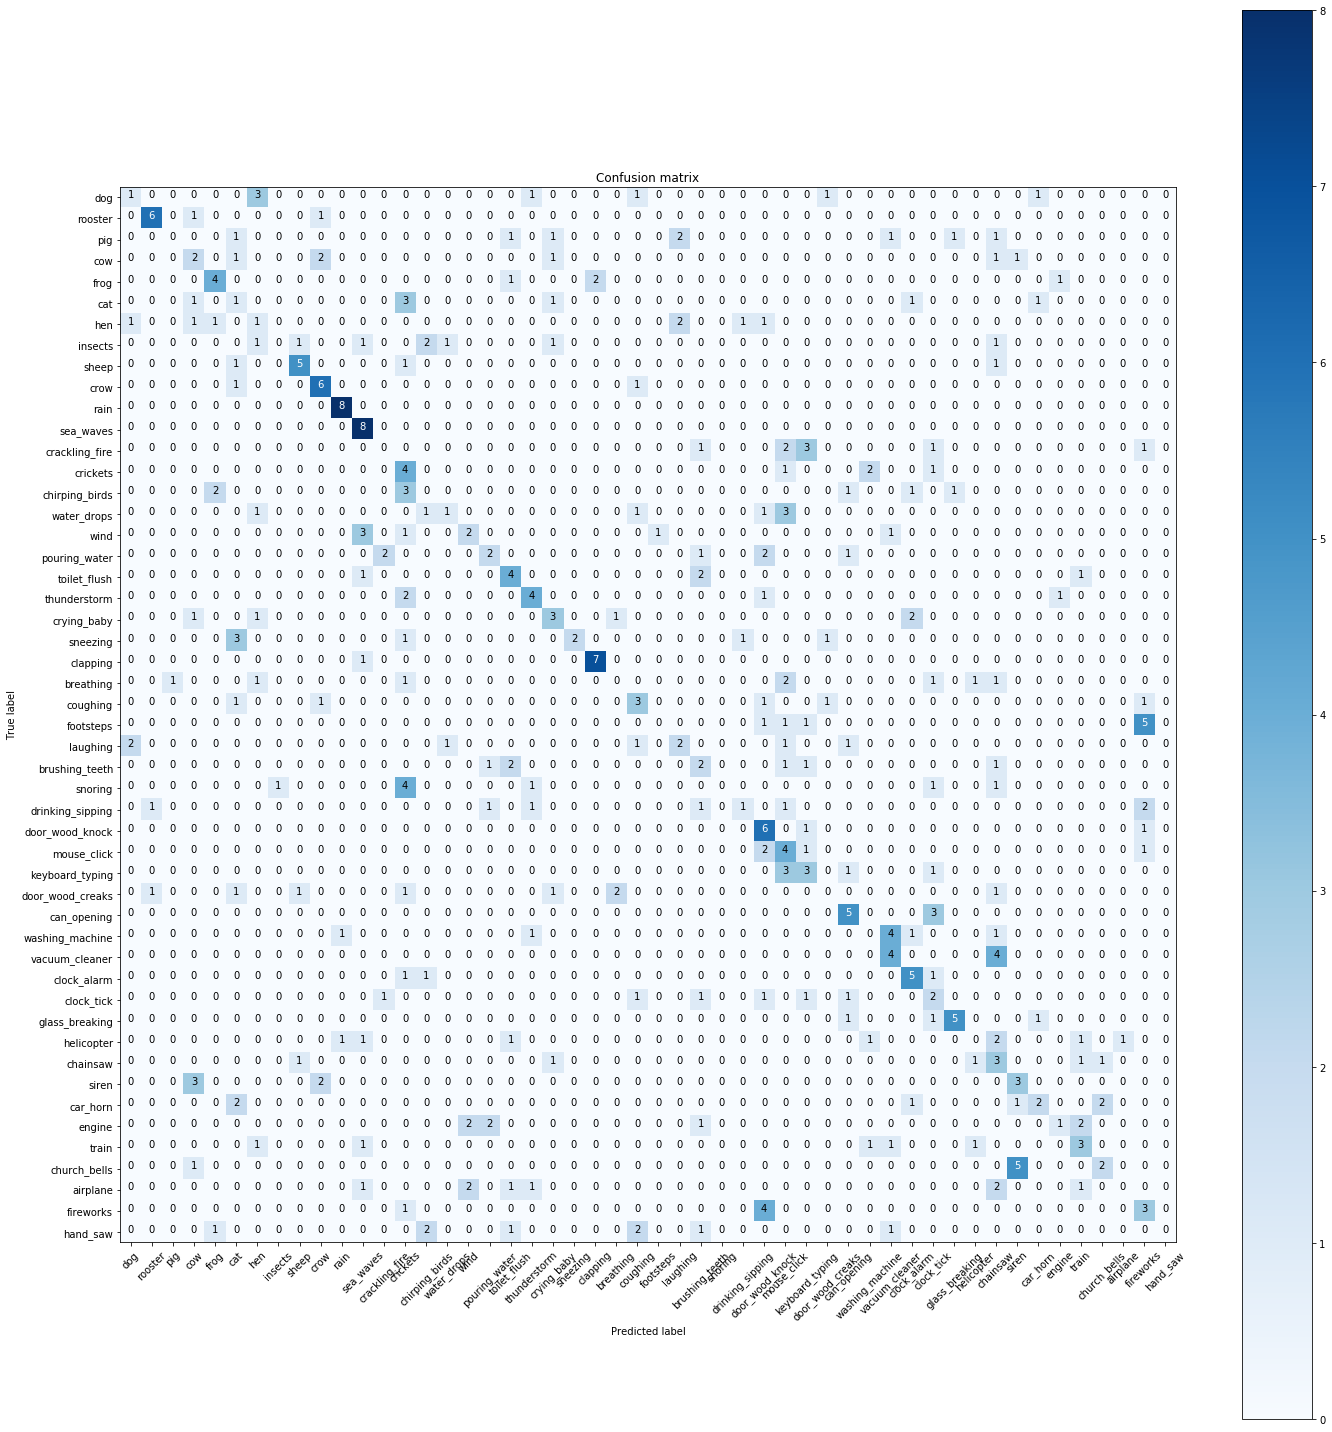

In [19]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [20]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)[0]

        prob = clf.predict_proba(x_file)[l_l]
        pred = clf.predict(x_file[np.newaxis, :, :, :])
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [21]:
%%time
preds = query_dataset('dog')

CPU times: user 7min 52s, sys: 1min 13s, total: 9min 6s
Wall time: 1min 41s


In [22]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [23]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.4

In [24]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 7min 29s, sys: 1min 52s, total: 9min 21s
Wall time: 1min 45s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.61 ms
dog
0.4

CPU times: user 7min 53s, sys: 1min 12s, total: 9min 5s
Wall time: 1min 45s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 9.78 ms
rooster
0.6

CPU times: user 8min 3s, sys: 1min 8s, total: 9min 12s
Wall time: 1min 48s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 13.2 ms
pig
0.1

CPU times: user 7min 58s, sys: 1min 12s, total: 9min 11s
Wall time: 1min 47s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12 ms
cow
0.2

CPU times: user 7min 48s, sys: 1min 55s, total: 9min 44s
Wall time: 1min 52s
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.77 ms
frog
0.4

CPU times: user 7min 55s, sys: 1min 13s, total: 9min 8s
Wall time: 1min 49s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.4 ms
cat
0.1

CPU times: user 8min 5s, sys: 1min 8s, total: 9min 13s
Wall time: 1min 52s
CPU times: user 8 

0.30999999999999994